In [119]:
import os
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm as tqdm
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from datetime import datetime
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

In [120]:
print(torch.__version__)

1.12.1+cu116


In [121]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

print(device)

cuda


In [122]:
data_dir = str(Path(fr"./data/train.csv"))
testdata_dir = str(Path(fr"./data/test.csv"))
save_dir = str(Path(fr"./runs/exp"))

In [175]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1145

epoch_num = 300

dtype = torch.float64

# Learning Rate
LR = 1e-4
EPS = 1e-7
LR_STEP = 150
LR_GAMMA = 0.9

In [146]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        data = pd.read_csv(data_dir)
        self.inputs = data[['x1', 'x2']].to_numpy()
        self.outputs = data['y'].to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype= torch.float)
        output_data = torch.tensor(self.outputs[idx], dtype= torch.float)

        if self.transform:
            input_data = self.transform(input_data)

        return input_data, output_data

In [176]:
dataset = CustomDataset(data_dir)

train_size = int(1 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
               for x, y, z in zip(['train', 'valid'], [train_dataset, valid_dataset], [True, False])}


In [148]:
class DeepModelWithBN(nn.Module):
    def __init__(
            self, 
            layer_sizes):
        super().__init__()

        self.layers = nn.ModuleList()

        for i in range(len(layer_sizes) - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i + 1]).to(dtype)
            nn.init.xavier_uniform_(layer.weight)  # 使用Xavier初始化
            self.layers.append(layer)
            
            if i != len(layer_sizes) - 2:  # 不在最后一个线性层后使用批量归一化
                bn = nn.BatchNorm1d(layer_sizes[i + 1]).to(dtype)
                self.layers.append(bn)

        self.activation = nn.LeakyReLU(0.05)

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if isinstance(layer, nn.Linear):  # 只在线性层后使用激活函数
                x = self.activation(x)
        
        x = self.layers[-1](x)  # 最后一层不使用激活函数
        return x

In [177]:
model_name = 'DeepModelWithBN'
model_args = [[2, 32, 64, 128, 128, 64, 32, 1]]


model = DeepModelWithBN(*model_args)
# model = EasyModel()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, eps=EPS)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss()
# criterion = nn.PoissonNLLLoss()

In [178]:
ckpt = {
    'epoch': 0,
    'model_name': model_name,
    'model_args': model_args,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'criterion': criterion,
    'history': {
        'train_loss': [], 
        'valid_loss': [],
        'valid_loss_min': np.Inf,
        'train_loss_min': np.Inf,
        'best_acc': 0.0,
    },
    'readme': "",
    'date': datetime.now().isoformat(),
}

In [151]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        path, suffix = (path.with_suffix(
            ''), path.suffix) if path.is_file() else (path, '')

        # Method 1
        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # increment path
            if not os.path.exists(p):  #
                break
        path = Path(p)

        # Method 2 (deprecated)
        # dirs = glob.glob(f"{path}{sep}*")  # similar paths
        # matches = [re.search(rf"{path.stem}{sep}(\d+)", d) for d in dirs]
        # i = [int(m.groups()[0]) for m in matches if m]  # indices
        # n = max(i) + 1 if i else 2  # increment number
        # path = Path(f"{path}{sep}{n}{suffix}")  # increment path

    if mkdir:
        path.mkdir(parents=True, exist_ok=True)  # make directory

    return str(path)

In [153]:
def train(ckpt, 
          save_dir, 
          model, 
          dataloaders, 
          optimizer, 
          lr_scheduler=None,
          num_epochs=300, 
          device='cpu'):

    save_dir = Path(save_dir)
    save_dir = increment_path(
        Path(save_dir), exist_ok=(False if ckpt['epoch'] == 0 else True), mkdir=True)
    
    model = model.to(device)

    # initial
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if (lr_scheduler):
        lr_scheduler.load_state_dict(ckpt['lr_scheduler_state_dict'])
    criterion = ckpt['criterion']

    for epoch in range(1, num_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print(f"running epoch: {ckpt['epoch'] + 1}")

        # Training loop
        model.train()
        for inputs, outputs in dataloaders['train']:
            optimizer.zero_grad()
            
            inputs = inputs.to(dtype).to(device)
            outputs = outputs.to(dtype).to(device)

            predictions = model(inputs)
            loss = criterion(predictions.squeeze(1), outputs)
            loss.backward()
            optimizer.step()

            # update training loss
            train_loss += loss.item() * inputs.size(0)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for inputs, outputs in dataloaders['valid']:

                inputs = inputs.to(dtype).to(device)
                outputs = outputs.to(dtype).to(device)

                predictions = model(inputs)
                loss = criterion(predictions.squeeze(1), outputs)
                valid_loss += loss.item() * inputs.size(0)
        
        if (lr_scheduler):
            lr_scheduler.step()
        
        train_loss = train_loss / len(dataloaders['train'].dataset)
        if len(dataloaders['valid'].dataset):
            valid_loss = valid_loss / len(dataloaders['valid'].dataset)

        ckpt['history']['train_loss'].append(train_loss)
        ckpt['history']['valid_loss'].append(valid_loss)

        print(
            f'Train loss     -> {train_loss:.6f}      \
                Validation loss     -> {valid_loss:.6f}')
        
        # update and save check point information
        ckpt['epoch'] += 1
        ckpt['model_state_dict'] = model.state_dict()
        ckpt['optimizer_state_dict'] = optimizer.state_dict()
        if (lr_scheduler):
            ckpt['lr_scheduler_state_dict'] = lr_scheduler.state_dict()
        ckpt['date'] = datetime.now().isoformat()

        # save model if validation loss has decreased
        if valid_loss <= ckpt['history']['valid_loss_min']:
            print(
                f"Validation loss decreased ({ckpt['history']['valid_loss_min']:.6f} \
                    --> {valid_loss:.6f}).  Saving model ...")
            ckpt['history']['valid_loss_min'] = valid_loss
            torch.save(ckpt, str(Path(save_dir) / Path('valid_best.pth')))
        # save model if validation loss has decreased
        if train_loss <= ckpt['history']['train_loss_min']:
            print(
                f"train loss decreased ({ckpt['history']['train_loss_min']:.6f} \
                    --> {train_loss:.6f}).  Saving model ...")
            ckpt['history']['train_loss_min'] = train_loss
            torch.save(ckpt, str(Path(save_dir) / Path('train_best.pth')))

        torch.save(ckpt, str(Path(save_dir) / Path('last.pth')))

    return ckpt

In [116]:
# ckpt['model_state_dict'] = torch.load(str(Path(fr"./runs/exp") / Path('last.pth')))['model_state_dict']

In [96]:
ckpt['lr_scheduler_state_dict'] = None

In [99]:
ckpt['optimizer_state_dict']

{'state': {0: {'step': tensor(40066.),
   'exp_avg': tensor([[-2.4204e-05,  2.0134e-03],
           [-2.2131e-02, -1.9373e-03],
           [ 3.2562e-03,  3.7216e-03],
           [-3.7156e-03, -7.7394e-04],
           [ 4.7772e-03, -3.8439e-03],
           [ 2.1507e-03,  1.6716e-03],
           [ 1.4467e-04, -4.3085e-03],
           [-5.2666e-03, -2.9692e-03],
           [ 5.4739e-03, -5.9974e-04],
           [-4.3835e-03,  1.5429e-03],
           [-2.7603e-03, -7.6219e-03],
           [-2.6633e-04, -4.5427e-03],
           [ 6.2562e-03,  1.0761e-02],
           [-2.9465e-03, -2.4160e-03],
           [-8.8496e-04,  4.3796e-03],
           [-7.8553e-03,  2.8545e-03]], device='cuda:0', dtype=torch.float64),
   'exp_avg_sq': tensor([[8.6170e-04, 4.6500e-04],
           [2.9315e-02, 3.0473e-03],
           [4.1941e-04, 5.8533e-04],
           [1.4618e-03, 7.3952e-04],
           [1.7227e-03, 8.7787e-04],
           [8.3596e-04, 4.1612e-04],
           [1.6335e-04, 5.0327e-04],
           [5

In [179]:
ckpt = train(ckpt, save_dir, model, dataloaders, optimizer, lr_scheduler=lr_scheduler, num_epochs=3000, device=device)

running epoch: 1
Train loss     -> 2.250417                      Validation loss     -> 0.000000
Validation loss decreased (inf                     --> 0.000000).  Saving model ...
train loss decreased (inf                     --> 2.250417).  Saving model ...
running epoch: 2
Train loss     -> 1.592922                      Validation loss     -> 0.000000
Validation loss decreased (0.000000                     --> 0.000000).  Saving model ...
train loss decreased (2.250417                     --> 1.592922).  Saving model ...
running epoch: 3
Train loss     -> 1.460211                      Validation loss     -> 0.000000
Validation loss decreased (0.000000                     --> 0.000000).  Saving model ...
train loss decreased (1.592922                     --> 1.460211).  Saving model ...
running epoch: 4
Train loss     -> 1.378627                      Validation loss     -> 0.000000
Validation loss decreased (0.000000                     --> 0.000000).  Saving model ...
train loss dec

In [ ]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

train_losses_k = []
valid_losses_k = []

# 开始K折交叉验证
for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold + 1}")

    # 创建训练和验证数据集
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)

    # 创建训练和验证数据加载器
    train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # 初始化模型、损失函数和优化器
    model = DeepModelWithBN([2, 100, 100, 1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer, device)
        val_loss = validate(model, val_dataloader, criterion, device)

        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 保存训练和验证损失
    train_losses_k.append(train_loss)
    valid_losses_k.append(valid_loss)

# 输出交叉验证结果
print(f"Average Train Loss: {np.mean(train_losses):.4f}, Average Val Loss:

In [ ]:
def k_fold_cross_validation(dataset, model_class, k_folds=5, epochs=100, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    kfold = KFold(n_splits=k_folds, shuffle=True)

    fold_train_losses = []
    fold_val_losses = []
    fold_best_models = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}")

        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False)

        model = model_class().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        early_stopping = EarlyStopping(patience=5, delta=0.0001)

        best_val_loss = float("inf")
        best_model_weights = None

        for epoch in range(epochs):
            train_loss = train(model, train_dataloader, criterion, optimizer, device)
            val_loss = validate(model, val_dataloader, criterion, device)

            print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = model.state_dict().copy()

            if early_stopping(val_loss):
                print("Early stopping triggered.")
                break

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_best_models.append(best_model_weights)

    return fold_train_losses, fold_val_losses, fold_best_models


In [136]:
ckpt['lr_scheduler_state_dict']

{'step_size': 150,
 'gamma': 0.9,
 'base_lrs': [0.0001],
 'last_epoch': 5000,
 '_step_count': 5001,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [3.090315438263264e-06]}

Text(0, 0.5, 'loss')

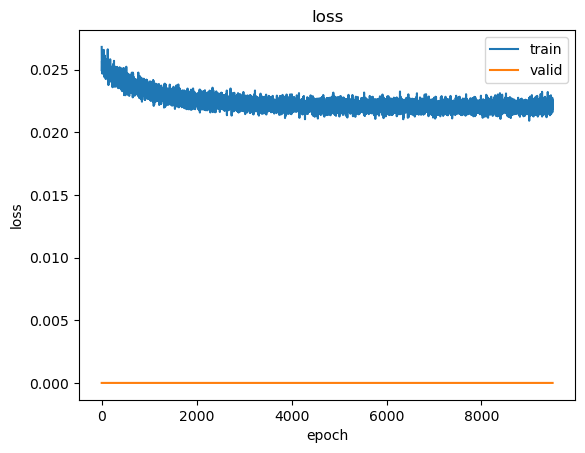

In [157]:
# loss 
plt.plot(ckpt['history']['train_loss'][500:],label='train')
plt.plot(ckpt['history']['valid_loss'][500:],label='valid')
plt.legend()
# plt.xlim(50,)
# plt.ylim(0,0.1)
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [96]:
k = iter(dataloaders['train'])
x, y = next(k)

print(x.shape)
print(y.shape)

torch.Size([256, 2])
torch.Size([256])


In [14]:
ckpt = torch.load(str(Path(fr"./runs/exp12") / Path('last.pth')))
print(ckpt.keys)
# model = DeepModelWithBN(ckpt[])

<built-in method keys of dict object at 0x000002B412354080>


In [172]:
model.load_state_dict(torch.load(str(Path(fr"./runs/exp22") / Path('train_best.pth')))['model_state_dict'])

<All keys matched successfully>

In [173]:
model.to(device)

data = pd.read_csv(testdata_dir)
x = data[['x1', 'x2']].to_numpy()
x = torch.tensor(x, dtype=dtype)
model.eval()
with torch.no_grad():
    y = model(x.to(device))


In [174]:
y = y.squeeze().cpu().numpy()
ids = np.arange(1, 2001)
df = pd.DataFrame({'id': ids, 'y': y})
df.to_csv('output_best.csv', index=False)

In [161]:


# 讀取兩個CSV檔
csv1 = pd.read_csv('output.csv')
csv2 = pd.read_csv('output2.csv')

# 使用相同的id將兩個dataframe合併
merged_csv = csv1.merge(csv2, on='id', suffixes=('_1', '_2'))

# 計算y值的平均值
merged_csv['y'] = (merged_csv['y_1'] + merged_csv['y_2']) / 2

# 保存到新的CSV檔
merged_csv[['id', 'y']].to_csv('output_file.csv', index=False)

<Figure size 640x480 with 0 Axes>

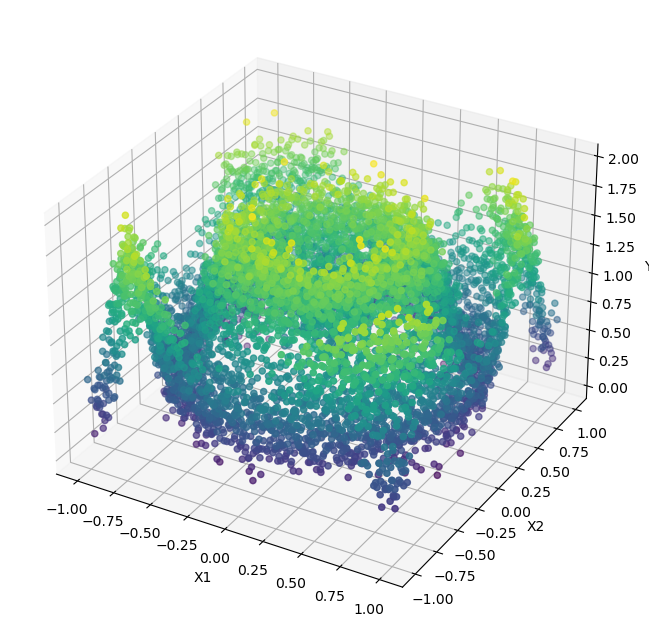

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv(data_dir)

# 創建一個3D圖形
fig = plt.figure()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 繪製散點圖
ax.scatter(data['x1'].to_numpy(), data['x2'].to_numpy(), data['y'].to_numpy(), c=data['y'].to_numpy(), cmap='viridis', marker='o')

# 設置標籤
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')



# 顯示圖形
plt.show()

In [109]:
import numpy as np

# 設定網格點的數量
grid_size = 100

# 使用linspace在-1和1之間創建均勻間隔的值
x_values = np.linspace(-1, 1, grid_size)
y_values = np.linspace(-1, 1, grid_size)

# 使用meshgrid創建網格座標
x_grid, y_grid = np.meshgrid(x_values, y_values)

# 將網格座標陣列整形為2D點陣列
x = np.column_stack((x_grid.flatten(), y_grid.flatten()))

x_t = torch.tensor(x, dtype=dtype)
model = model.to(device)
model.eval()
with torch.no_grad():
    y = model(x_t.to(device))
y = y.squeeze().cpu().numpy()

In [28]:
y.shape

(10000,)

In [33]:

# ids = np.arange(1, 2001)
# df = pd.DataFrame({'id': ids, 'y': y})
# df.to_csv('.csv', index=False)

In [31]:
df = pd.DataFrame({'x1': x[:, 0], 'x2': x[:, 1], 'y': y})
df.to_csv('.csv', index=False)

In [32]:
df

,x1,x2,y
0,-1.000000,-1.0,0.442851
1,-0.979798,-1.0,0.410066
2,-0.959596,-1.0,0.355262
3,-0.939394,-1.0,0.388738
4,-0.919192,-1.0,0.440852
...,...,...,...
9995,0.919192,1.0,0.429789
9996,0.939394,1.0,0.375496
9997,0.959596,1.0,0.320881
9998,0.979798,1.0,0.260588


<Figure size 640x480 with 0 Axes>

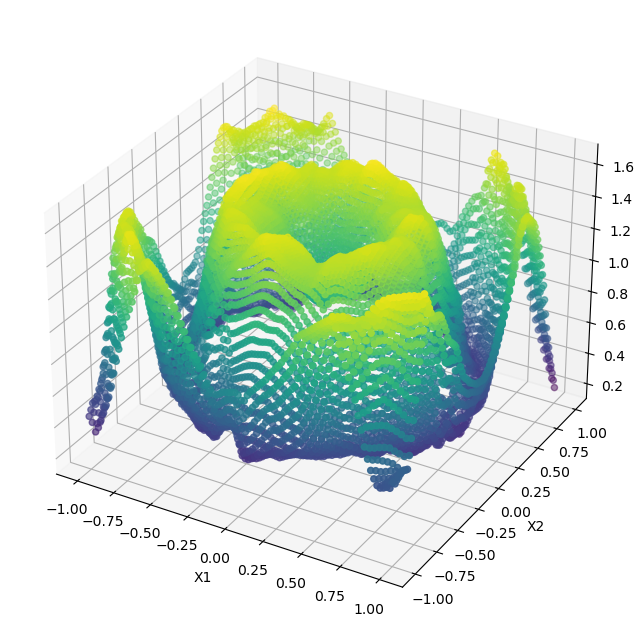

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D

data = df

# 創建一個3D圖形
fig = plt.figure()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 繪製散點圖
ax.scatter(data['x1'].to_numpy(), data['x2'].to_numpy(), data['y'].to_numpy(), c=data['y'].to_numpy(), cmap='viridis', marker='o')

# 設置標籤
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')



# 顯示圖形
plt.show()

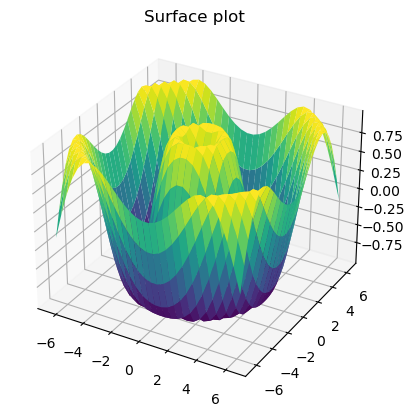

In [65]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

a = 2.5
b = 0.6
c = 6.4

x = np.outer(np.linspace(-c, c, 30), np.ones(30))
y = x.copy().T # transpose

z = np.sin(np.sqrt(a * (x * b)**2 + a * (y * b)**2))

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()